# Module 6. Bivariate analysis of 2 quantitative variables

In this module, we discuss the case where both variables are quantitative. Specifically, we'll explore the concept of *linear regression*. Other analysis methods do exist, but those are beyond the scope of this course.

Regression analysis is an extremely flexible tool that can aid decision
making in many areas. [Kimes and Fitzsimmons (1990)](https://ecommons.cornell.edu/handle/1813/72194) describe how
it has been used by La Quinta Motor Inns, a moderately priced hotel
chain oriented toward serving the business traveler, to help make site
location decisions. 

There are two potential objectives of regression analysis. The first objective is to understand how the world operates, for example, one might try to discover whether there is any
gender discrimination in salaries, taking into account differences in work experience and
education level.  
The second objective is to make predictions. A good example of this is
when the variable in question is company sales, and variables such as advertising and past
sales levels are used as explanatory variables.

In [ ]:
# Package imports
import numpy as np                                  # "Scientific computing"
import scipy.stats as stats                         # Statistical tests

import pandas as pd                                 # Dataframe
import matplotlib.pyplot as plt                     # Basic visualisation
from statsmodels.graphics.mosaicplot import mosaic  # Mosaic plot
import seaborn as sns                               # Advanced dataviz

## Visualization

A good way to begin any regression analysis is to draw one or more scatterplots. If there
is any relationship between the two variables, it is usually apparent from the scatterplot.  
To visualize quantitative data, we can use Seaborn's `relplot()` function. The independent variable should be mapped to the X-axis, the dependent variable to the Y-axis.  
In the example below we will use the Penguins dataset.

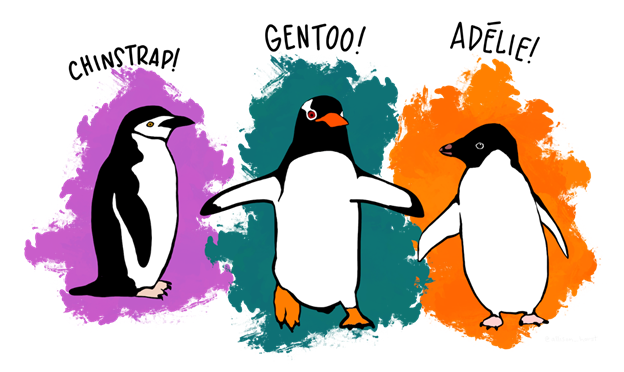

In [ ]:
penguins = sns.load_dataset('penguins') # Load the Palmer Penguins demo dataset
penguins.head()

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
3          NaN     NaN  
4       3450.0  Female

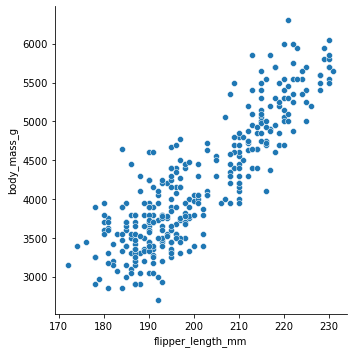

In [ ]:
sns.relplot(data=penguins,  x='flipper_length_mm', y='body_mass_g')

Using other chart attributes like hue, style, etc. you can also visualize categorical variables in the data set, e.g.:

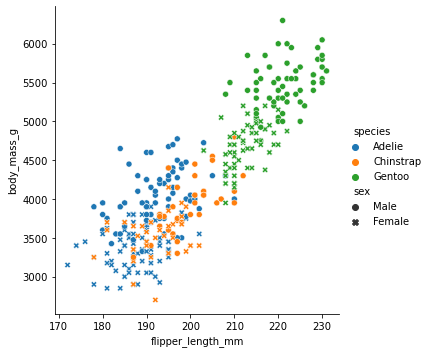

In [ ]:
sns.relplot(data=penguins,
            x='flipper_length_mm', y='body_mass_g', 
            hue='species', style='sex')

Another example:

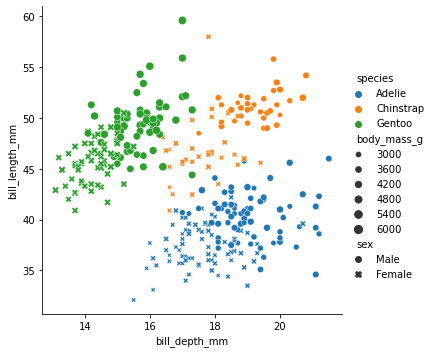

In [ ]:
sns.relplot(data=penguins,
            x='bill_depth_mm', y='bill_length_mm',
            size='body_mass_g', 
            hue='species', style='sex')

## Method of Least Squares: Introduction

Scatterplots are very useful for indicating linear relationships and the
strengths of these relationships. But they do not actually quantify the relationships. For
example, it is clear from the scatterplot that `body_mass_g` is related
to `flipper_length_mm`, but the scatterplot does not specify exactly what this relationship 
is. If the `flipper_length_mm` is 190, what would you predict `body_mass_g` to be?  
To
answer these questions, the relationship between the dependent variable `body_mass_g` and the
explanatory variable `flipper_length_mm` must be quantified.  
To reduce the number of points in the scatterplot and make the plots as clear as possible, we are going to take only the male, Chinstrap penguins into account.

In [ ]:
male_chinstrap = penguins[(penguins['species'] == 'Chinstrap') & (penguins['sex'] == 'Male')]
male_chinstrap.head()

species island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
153  Chinstrap  Dream            50.0           19.5              196.0   
154  Chinstrap  Dream            51.3           19.2              193.0   
156  Chinstrap  Dream            52.7           19.8              197.0   
159  Chinstrap  Dream            51.3           18.2              197.0   
161  Chinstrap  Dream            51.3           19.9              198.0   

     body_mass_g   sex  
153       3900.0  Male  
154       3650.0  Male  
156       3725.0  Male  
159       3750.0  Male  
161       3700.0  Male

Some male, Chinstrap penguins have the same `flipper_length_mm`, but a different `body_mass_g`. To simplify things, we calculate the average value for `body_mass_g` per `flipper_length_mm`.

In [ ]:
male_chinstrap = male_chinstrap.groupby('flipper_length_mm')['body_mass_g'].mean().reset_index()
male_chinstrap.head(10)

flipper_length_mm  body_mass_g
0              187.0  3250.000000
1              191.0  3400.000000
2              193.0  3741.666667
3              194.0  3775.000000
4              195.0  4000.000000
5              196.0  3725.000000
6              197.0  3675.000000
7              198.0  3700.000000
8              200.0  3800.000000
9              201.0  4160.000000

The data is plotted on an XY graph. 

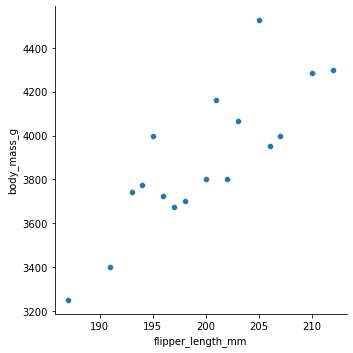

In [ ]:
sns.relplot(data=male_chinstrap, x='flipper_length_mm', y='body_mass_g')

The scatterplot above hints at a linear
relationship between these two variables. It would not be diffcult to draw a straight
line through these points to produce a reasonably good fit. But which is the best line to use?
A line can be defined by $$y = ax + b$$ in which $a$ is the slope of the line and $b$ is the intercept of the line (that's the location on the Y axis that the line crosses when X equals 0).
We will use the following values for $a$ and $b$:  
`a = 37 and b = -3385`  
`a = 23 and b = -820`  
`a = 23 and b = -715`  
`a = 20.5 and b = -92`  
`a = 29 and b = -1635`  
We need a way to 'calculate' if one line is a better fit than another line.  
For that we will use the sum of squared residuals.

**What is a residual?**  
Consider the following image. Three points in the scatterplot are shown, along with a straight line. The vertical distance from the horizontal axis to any point, can be decomposed into two parts: the vertical distance from the horizontal axis to the line, and the vertical distance from the line to the point. The first of these is called the fitted value,
and the second is called the residual. So a fitted value is the predicted value of the dependent variable. The corresponding residual is the difference between the actual and fitted values of the dependent variable.

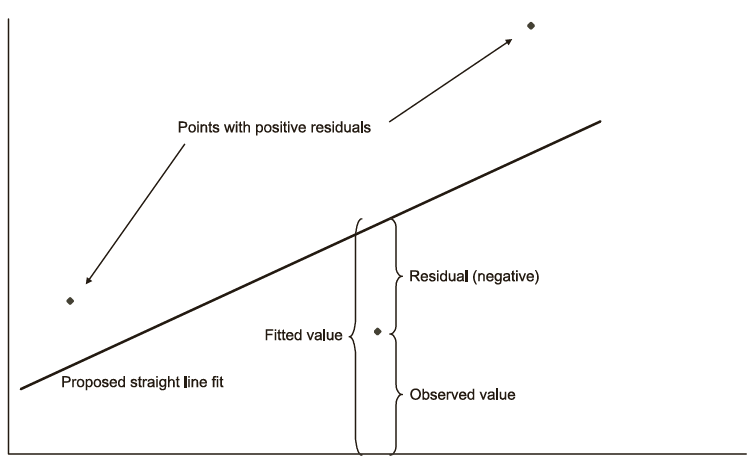


In the following 5 blocks, a small animation is created to try to find the straight line that fits the points the best.  
The dotted green lines are the residuals.

In [ ]:
from matplotlib.collections import LineCollection
import math
# set the minimum and maximum value of the x- and y-axis
xmin = math.floor(male_chinstrap['flipper_length_mm'].min() / 10) * 10
xmax = math.ceil(male_chinstrap['flipper_length_mm'].max() / 10) * 10

ymin = math.floor(male_chinstrap['body_mass_g'].min() / 10) * 10
ymax = math.ceil(male_chinstrap['body_mass_g'].max() / 10) * 10

a_values = [37, 23, 23, 20.5, 29]
b_values = [-3385, -820, -715, -92, -1635]


In [ ]:
fig, axs = plt.subplots(figsize=(8, 8));

import time

def animate(i):
  len_male_chinstrap_plus_2 = len(male_chinstrap) + 2

  j = i // len_male_chinstrap_plus_2
  k = i % len_male_chinstrap_plus_2

  # alles leegmaken
  axs.clear()

  # axs instellen
  axs.set_xlim([xmin, xmax])
  axs.set_ylim([ymin, ymax])

  # punten tekenen
  for l in range(len(male_chinstrap)): 
    axs.plot(male_chinstrap.iloc[l, 0], male_chinstrap.iloc[l, 1], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")    
    

  if (k == 0):  
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axs.text(0.05, 0.95, f'Attempt n° {j + 1}', transform=axs.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    print()


  if k > 0:
    # rechte tekenen
    x_values = [xmin + 2, xmax - 2]
    y_values = [a_values[j] * x_values[0] +  b_values[j], a_values[j] * x_values[1] + b_values[j]]
    axs.plot(x_values, y_values, lw = 3)

  if k > 1:   
    # lijn segmenten toevoegen
    segs = []
    sum_squared_residuals = 0
    for q in range(k - 1):
      sum_squared_residuals +=  ((a_values[j] * male_chinstrap.iloc[q, 0] +  b_values[j]) - male_chinstrap.iloc[q, 1]) ** 2 
      segs.append([(male_chinstrap.iloc[q, 0], a_values[j]  * male_chinstrap.iloc[q, 0] +  b_values[j]),(male_chinstrap.iloc[q, 0], male_chinstrap.iloc[q, 1])])
    lc = LineCollection(segs, linewidths=1, colors='g', linestyle='dashed')
    axs.add_collection(lc)
    
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    axs.text(0.05, 0.95, f'Sum Squared Residuals = {sum_squared_residuals:5.2e}', transform=axs.transAxes, fontsize=14, verticalalignment='top', bbox=props)



In [ ]:
# calculating the frames needed
len_male_chinstrap_plus_2 = len(male_chinstrap) + 2

frames = []
for i in range(len(a_values)):
  frames.append(i * len_male_chinstrap_plus_2)
  frames.append(i * len_male_chinstrap_plus_2)
  frames.append(i * len_male_chinstrap_plus_2 + 1)
  frames.append(i * len_male_chinstrap_plus_2 + 1)
  for j in range(len(male_chinstrap)):
    frames.append(i * len_male_chinstrap_plus_2 + 2 + j)
  frames.append(i * len_male_chinstrap_plus_2 + 2 + j)
  frames.append(i * len_male_chinstrap_plus_2 + 2 + j)



In [ ]:
from matplotlib import rc
rc('animation', html='jshtml')

In [ ]:
from matplotlib.animation import FuncAnimation
anim = FuncAnimation(fig, animate, frames=frames, interval=1000, repeat=False)

anim

We can measure how well a line fits the data by seeing how close it is to the data points. We'll start with the point in the lower left-hand corner of the graph. We can draw a dashed line from this point up to the gray line. The **residual** is the difference beteen the actual and fitted values of the dependent variable. The term is squared to ensure that each term is positive. 
Finally we take the sum of all the squared residuals between the line and the data points. This is called the **sum of squared residuals**.  
Note: If we would simply use the sum of the residuals, the positive residuals would cancel the negative residuals. We could also minimize the sum of the _absolute values_ of the residuals and this would be a perfectly reasonable procedure. However, for technical and historical reasons,
it is not the procedure usually chosen.

### Method of least squares

The **least squares line** is the line that minimizes the sum of the squared residuals.

The minimization problem itself is a calculus problem, but in essence we want to approximate a collection of points $(x_i, y_i)$ (with $i: 1, \ldots, n$) as closely as possible with a line $$\hat{y} = \beta_0 + \beta_1 x.$$ The notation $\hat{y}$ stands for "an estimation for $y$". Parameters $\beta_0$ (intercept with the Y axis) and $\beta_1$ (slope) are calculated as follows:


$\beta_1 = \displaystyle \frac{\sum_{i=1}^{n}(x_i - \overline{x})(y_i - \overline{y})}{\sum_{i=1}^{n}(x_i - \overline{x})^2}$

$\beta_0 = \overline{y} - \beta_1 \overline{x}$

These values for $\beta_0$ and $\beta_1$ will minimize the sum of the squared residuals between the observed and the fitted values (hence the name of the "method of least squares"). The proof to obtain these values is beyond the scope of this course.

We can calculate $\beta_0$ and $\beta_1$ in Python as follows:

In [ ]:
mx = male_chinstrap.flipper_length_mm.mean()
my = male_chinstrap.body_mass_g.mean()
xx = male_chinstrap.flipper_length_mm - mx
yy = male_chinstrap.body_mass_g - my
beta1 = sum(xx * yy) / sum(xx ** 2)
beta0 = my - beta1 * mx

# Regression line equation
print(f"ŷ = {beta0:.2f} + {beta1:.2f} x")

ŷ = -3868.33 + 38.83 x


Let's check if the values for $\beta_0$ and $\beta_1$ provide a good approximation of the observed data:

<AxesSubplot:xlabel='flipper_length_mm', ylabel='body_mass_g'>

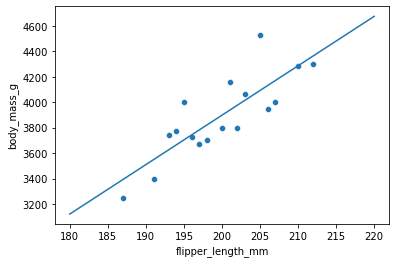

In [ ]:
x_values = [xmin, xmax]
y_values = [beta1 * x_values[0] + beta0, beta1 * x_values[1] + beta0]

sns.lineplot(x=x_values, y=y_values)
sns.scatterplot(x=male_chinstrap.flipper_length_mm, y=male_chinstrap.body_mass_g)


You can plot a data set **with its regression line** as follows:

<AxesSubplot:xlabel='flipper_length_mm', ylabel='body_mass_g'>

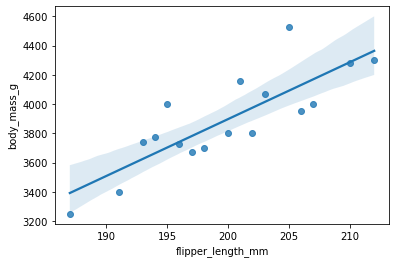

In [ ]:
sns.regplot(x=male_chinstrap.flipper_length_mm, y=male_chinstrap.body_mass_g)

The regression line corresponds with the one we drew using the calculated parameters!  

The formulas for the slope and intercept in simple linear regression, are rather for conceptual purposes. Virtually all statistical software packages perform this minimization automatically.

E.g. the Python library **scikit-learn** has code to calculate a linear regression model from a set of observations.

We can then create an instance of the class `LinearRegression` and pass the X- and Y-values to be fitted. The array with X-values must be first converted in a 2D array.

In [ ]:
from sklearn.linear_model import LinearRegression

male_chinstrap_x = male_chinstrap.flipper_length_mm.values.reshape(-1,1)
male_chinstrap_y = male_chinstrap.body_mass_g

weight_model = LinearRegression().fit(male_chinstrap_x, male_chinstrap_y)

print(f"Regression line: ŷ = {weight_model.intercept_:.2f} + {weight_model.coef_[0]:.2f} x")

Regression line: ŷ = -3868.33 + 38.83 x


## Covariance

**Covariance** is a measure that indicates whether a (linear) relationship
between two variables is increasing or decreasing.

Covariance is defined as: $$\mathrm{Cov}(X,Y) = \frac{1}{n-1}\sum_{i=1}^n(x_i - \overline{x})(y_i - \overline{y})$$

Note: Covariance of population (denominator 𝑛) vs. sample (denominator 𝑛 − 1)

Covariance is essentially an average of products of deviations from means. If _X_ and _Y_ vary in the same direction, then when _X_ is above its mean, _Y_ will tend to be above its mean, and when _X_ is below its mean,
_Y_ will tend to be below its mean. In either case, the product of deviations will be positive—
a positive times a positive or a negative times a negative—so the covariance will be positive.
The opposite is true when _X_ and _Y_ vary in opposite directions. Then the covariance
will be negative.

Covariance measures the direction of a linear relationship between two
numerical variables. If this straight line rises from left to right, the relationship
is positive and the covariance will be a positive number. If it falls from left to right,
the relationship is negative and the covariance will be a negative number.


Cov > 0: increasing  
Cov ≈ 0: no relationship  
Cov < 0: decreasing 

We'll define a `DataFrame` with the data used in the lecture slides:

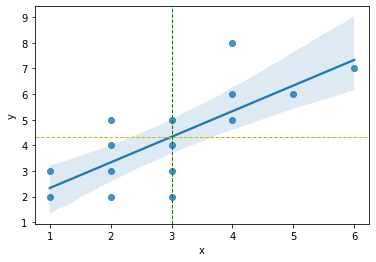

In [ ]:
families = pd.DataFrame(data={
    'x': [1,1,2,2,2,2,3,3,3,3,4,4,4,5,6],
    'y': [2,3,2,3,4,5,2,3,4,5,5,6,8,6,7]
})

sns.regplot(x=families.x, y=families.y) # data set with its regression line
plt.axvline(families.x.mean(), lw=1, color='g', linestyle='dashed')  # Plot mean of x
plt.axhline(families.y.mean(), lw=1, color='y', linestyle='dashed')  # Plot mean of y

In [ ]:
mx = families.x.mean()
my = families.y.mean()

covar = sum((families.x - mx) * (families.y - my)) / (len(families.x) - 1)
print(f"Cov(x,y) = {covar}")

Cov(x,y) = 2.0


To calculate covariance, you can use the Numpy function `cov`. It's a bit complicated to use, because it returns not a single value, but a covariance matrix:

```
cov(a,a)  cov(a,b)
cov(b,a)  cov(b,b)
```

Remark that the definition of `cov(a,a)` reduces to the variance of `a`!

We can extract the value we need with:

In [ ]:
np.cov(families.x, families.y, ddof=1)[0][1]

2.0

Remark that we use the parameter `ddof=1` for an unbiased estimate from the sample!



Covariance has a serious limitation as a descriptive measure because it is very sensitive
to the units in which X and Y are measured. For example, if _X_ is the height of a person and _Y_ is the weight of a person, the covariance can be inflated
by a factor of 100 simply by measuring _X_ in centimeters instead of meters. This
limits the usefulness of covariance as a descriptive measure

### Pearson's product-moment correlation coefficient

Correlation (or, specifically, Pearson's product-moment correlation coefficient) is defined as:

$$R = \frac{\mathrm{Cov}(X,Y)}{\sigma_x \sigma_y} = \frac{\sum(x_i - \overline{x})(y_i - \overline{y})}{\sqrt{\sum{(x_i-\overline{x})^2}} \sqrt{\sum{(y_i - \overline{y})^2}}}$$

𝑅 is a measure for
the strength of a linear correlation between 𝑥 and 𝑦.

Correlation is a _unitless_ quantity that is unaffected by the measurement scale. For example, the correlation
is the same regardless of whether the variable _X_ (e.g. height of a person) is measured in millimeters, centimeters, decimeters or meters.

The correlation is not only unaffected by the units of measurement of the two variables, but it is always between −1 and +1. The closer it is to either of these two extremes, the closer the points in a scatterplot are to a straight line, either in the negative or positive direction.  
On the other hand, if the correlation is close to 0, the scatterplot is typically a 'cloud' of points with no apparent relationship. However, although it is not common, it is also _possible_ that the points are close to a curve and have a correlation close to 0. This is because correlation is relevant only for measuring **linear** relationships.

In [1]:
# Correlation calculated from covariance
cor = covar / (families.x.std() * families.y.std())

NameError: name 'covar' is not defined

In [ ]:
# Correlation from elaborated formula
xx = families.x - families.x.mean()
yy = families.y - families.y.mean()
R2 = sum(xx * yy) / (np.sqrt(sum(xx ** 2) * sum(yy ** 2)))
print(f"R = {R2}")

R = 0.7533708035008839


In [ ]:
# Python function numpy.corrcoef() - returns a matrix, like numpy.cov()
cor = np.corrcoef(families.x, families.y)[0][1]
print(f"R = {cor}")

R = 0.7533708035008838


### Coefficient of determination

The coefficient of determination $R^2$ explains the percentage of the
variance of the observed values relative to the regression line, i.e. the interpretation of $R^2$ is 'the fraction of variation of the dependent variable explained by the regression line'. The closer to 1, the more the variance is explained by the regression line, and the stronger the linear relation between the variables: when the residuals are small, $R^2$ will be close to 1, but when they are large, $R^2$ will be close to 0. Graphically, the higher the coefficient of determination, the closer the observations are located near the regression line.

The determination coefficient can be calculated as the square of Pearson's correlation coefficient:

In [ ]:
cor ** 2

0.5675675675675673

So for this case, about 57% of the variance in the observations is explained by the regression line, which indicates a strong linear relation (see below).

The `LinearModel` class also has a method to calculate the coefficient of determination. We first need to call the `fit()` method and then we can use the method `score()` that returns $R^2$

In [ ]:
familiesx = families.x.values.reshape(-1,1)
familiesy = families.y

families_model = LinearRegression().fit(familiesx, familiesy)
families_model.score(familiesx, familiesy)

0.5675675675675678

### Interpretation of R and R²

Depending on the value of $|R|$ (or $R^2$), you can draw a conclusion about the strength of the linear relation between the two variables:

| $abs(R)$  |  $R^2$   | Explained variance |   Linear relation    |
| :-------: | :------: | :----------------: | :------------------: |
|   < .3    |   < .1   |       < 10%        |      very weak       |
|  .3 - .5  | .1 - .25 |     10% - 25%      |         weak         |
|  .5 - .7  | .25 - .5 |     25% - 50%      |       moderate       |
| .7 - .85  | .5 - .75 |     50% - 75%      |        strong        |
| .85 - .95 | .75 - .9 |     75% - 90%      |     very strong      |
|   > .95   |   > .9   |       > 90%        | exceptionally strong |

**Remark** that the value of $R$ doesn't say anything about the steepness of the regression line! It only indicates how close the observations are to the regression line. Therefore, it is **wrong** to say that a value of e.g. $R = 0.8$ indicates a strongly increasing linear relation! Instead, you should say it indicates an _increasing and strong linear relation_.


### Calculating covariance, $R$ and $R^2$ for penguins 

**Calculating covariance between `flipper_length_mm` and `body_mass_g` for male chinstrap**

In [ ]:
mx = male_chinstrap.flipper_length_mm.mean()
my = male_chinstrap.body_mass_g.mean()

covar = sum((male_chinstrap.flipper_length_mm - mx) * (male_chinstrap.body_mass_g - my)) / (len(male_chinstrap.flipper_length_mm) - 1)
print(f"Cov(x,y) = {covar}")


Cov(x,y) = 1835.9681372549016


* The value of the covariance is positive. This means as flipper_length gets a higher value, body_mass also becomes a bigger value
* Be aware! Flipper_length is now given in mm. If instead cm was used, this would affect the value of the covariance by a factor 10, although the data didn't really change.
* So the value of the covariance doesn't really tell us something.

**Calculating $R$  between `flipper_length_mm` and `body_mass_g` for male chinstrap**

In [ ]:
cor = np.corrcoef(male_chinstrap.flipper_length_mm, male_chinstrap.body_mass_g)[0][1]
print(f"R = {cor}")

R = 0.8268244668793293


* R indicates an increasing and strond linear relation between flipper_length and body_mass.

**Calculating $R^2$ between `flipper_length_mm` and `body_mass_g` for male chinstrap**

In [ ]:
print(f"R² = {cor ** 2}")

R² = 0.6836386990302872


* The `flipper_length_mm` vs. `body_mass_g` relationship accounts for 68% of the variation in `body_mass_g`.

In general

* $R^2$ is easier to interpret than $R$.
* The interpretation of $R^2$ as the square of a correlation helps to clarify the issue of when a correlation is "large".  


> * For example: how much better is R = 0.8 than R = 0.7 or R = 0.9? 
* If the correlation between two variables Y and X is
±0.8, the regression of Y on X will have an $R^2$ of 0.64; that is, the regression with X as the
only explanatory variable will explain 64% of the variation in Y.
* If the correlation drops to ±0.7, this percentage drops to 49%; 
* If the correlation increases to ±0.9, the percentage
increases to 81%. 

* The point is that before a single variable X can explain a large percentage of the variation in some other variable Y, the two variables must be highly correlated—in
either a positive or negative direction.

Another example: How much better is R = 0.7 than R = 0.5?  
R² = 0.7 * 0.7 ~ 0.5 => 50% of the original variation in explained  
R² = 0.5 * 0.5 = 0.25 => 25% of the original variation in explained  
With R², it is easy to see that the first correlation is twice as good as the second.
